In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [6]:
results_dir = Path("../results")
selected_models = [
    "phi4:14b",
    "qwen3:14b",
    "granite3.3:2b",
    "mistral:7b",
]

def load_results(pattern: str) -> pd.DataFrame:
    files = sorted(results_dir.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No result files found for pattern: {pattern}")

    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    df["avg_latency"] = pd.to_numeric(df["avg_latency"], errors="coerce")
    df["id_acc"] = pd.to_numeric(df["id_acc"], errors="coerce")
    df["ood_acc"] = pd.to_numeric(df["ood_acc"], errors="coerce")

    if "gqr_score" in df.columns:
        df["gqr_score"] = pd.to_numeric(df["gqr_score"], errors="coerce")
    else:
        df["gqr_score"] = 2 / (1 / df["id_acc"] + 1 / df["ood_acc"])

    return df

def plot_results(df: pd.DataFrame, title: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.scatter(df["avg_latency"], df["gqr_score"], color="#9e9e9e", s=80)

    for _, row in df.iterrows():
        offset = (6, -8) if row["model"] == "llama3.3:70b" else (6, 6)
        plt.annotate(
            row["model"],
            (row["avg_latency"], row["gqr_score"]),
            textcoords="offset points",
            xytext=offset,
            fontsize=8,
            fontweight="normal",
        )

    selected = df[df["model"].isin(selected_models)].copy()
    selected = selected.sort_values("avg_latency")
    if not selected.empty:
        plt.plot(
            selected["avg_latency"],
            selected["gqr_score"],
            color="red",
            marker="o",
            linestyle="--",
            linewidth=2,
            markersize=8,
        )

    plt.xscale("log")
    plt.xlabel("Time per sample (log scale)")
    plt.ylabel("GQR-Score")
    plt.title(title)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()


## Baseline (Current)


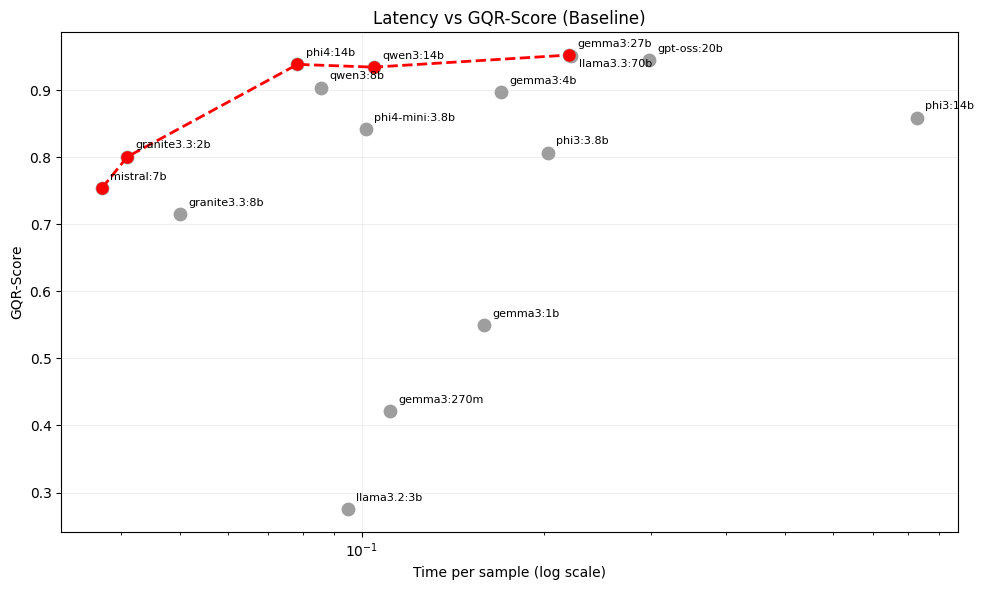

In [3]:
baseline_df = load_results("benchmark_results_*.csv")
plot_results(baseline_df, "Latency vs GQR-Score (Baseline)")


## Selected model comparison


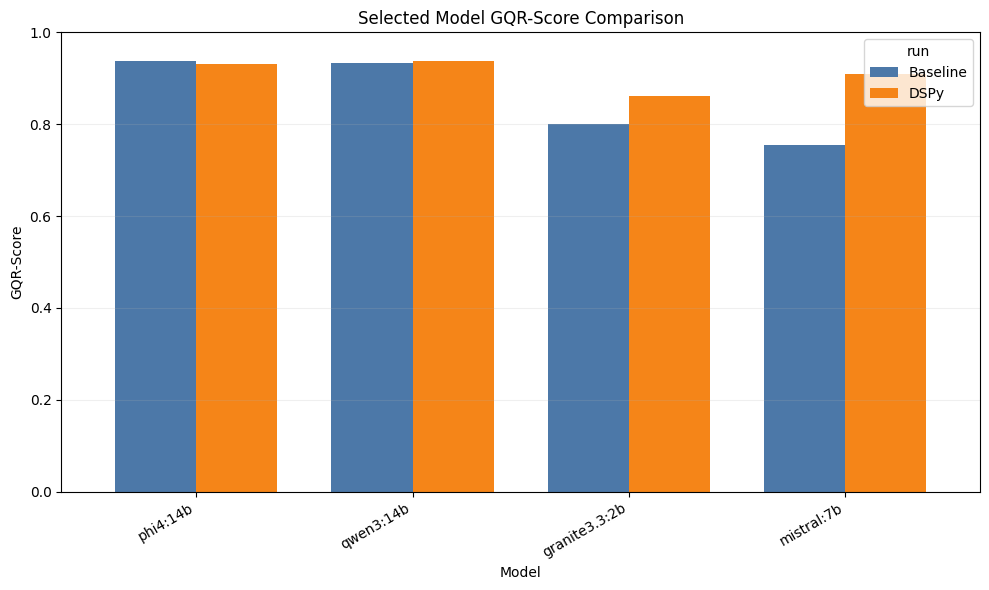

In [7]:
def try_load_results(pattern: str) -> pd.DataFrame | None:
    try:
        return load_results(pattern)
    except FileNotFoundError:
        return None

runs = {
    "Baseline": try_load_results("benchmark_results_*.csv"),
    "DSPy": try_load_results("dspy_results_*.csv"),
    "GEPA": try_load_results("gepa_results_*.csv"),
}

rows = []
for label, df in runs.items():
    if df is None:
        continue
    subset = df[df["model"].isin(selected_models)].copy()
    subset["run"] = label
    rows.append(subset)

if not rows:
    raise ValueError("No result files found for selected model comparison.")

plot_df = pd.concat(rows, ignore_index=True)
plot_df = plot_df.dropna(subset=["gqr_score"])
if plot_df.empty:
    raise ValueError("No selected model rows found for comparison.")

pivot = plot_df.pivot_table(
    index="model",
    columns="run",
    values="gqr_score",
    aggfunc="mean",
)
pivot = pivot.reindex(selected_models)

palette = ["#4c78a8", "#f58518", "#54a24b"]
ax = pivot.plot(
    kind="bar",
    figsize=(10, 6),
    width=0.75,
    color=palette[: len(pivot.columns)],
)
ax.set_xlabel("Model")
ax.set_ylabel("GQR-Score")
ax.set_title("Selected Model GQR-Score Comparison")
ax.set_ylim(0, 1.0)
ax.grid(axis="y", alpha=0.2)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
